In [22]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy
import glob
import re
import pickle
import bz2

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)
save_table = partial(util.save_table, save=True)

In [23]:
results_dir = os.path.join(util.ANALYSIS_DIR, 'D3_gmm')
diffGMM_files = glob.glob(os.path.join(results_dir, 'diffGMM*.pickle.bz2'))
diffGMM_files

['/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS_all.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_2005_2015.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_1996_2015.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS_subset.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI-KAOPEN_subset.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_2004_2015.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_1998_2015.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI_all.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI_subset.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_1999_2015.pickle.bz2',
 '/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all

In [24]:
def get(f):
    with bz2.BZ2File(f) as fd:
        return pickle.load(fd)


default = get('/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2')
rafiq_subset = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016_subset.pickle.bz2')
cts_subset = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS_subset.pickle.bz2')
cts_ti_subset = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI_subset.pickle.bz2')
cts_ti_kaopen_subset = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI-KAOPEN_subset.pickle.bz2')
rafiq_all = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016_all.pickle.bz2')
cts_all = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS_all.pickle.bz2')
cts_ti_all = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI_all.pickle.bz2')
cts_ti_kaopen_all = get('/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_Rafiq2016-CTS-TI-KAOPEN_all.pickle.bz2')

pd.testing.assert_frame_equal(default['pdynmc_coef'], cts_ti_kaopen_subset['pdynmc_coef'])
check = pd.concat([rafiq_subset['pdynmc_coef'], cts_ti_kaopen_subset['pdynmc_coef']], axis='columns')
check.loc[check.index.str.startswith('L')]

,Estimate,Std.Err.rob,z.value.rob,Pr...z.rob..,Estimate,Std.Err.rob,z.value.rob,Pr...z.rob..
L1.ENI,0.082117,1.253408,0.066,0.94738,0.393648,0.893465,0.441,0.65921
L2.ENI,-1.180484,0.587092,-2.011,0.04433,-0.280561,1.182598,-0.237,0.81266
L0.POP,-0.856509,0.930164,-0.921,0.35705,-0.023417,0.067311,-0.348,0.72784
L0.AFL,0.183848,0.133703,1.375,0.16913,0.042387,0.103116,0.411,0.68107
L0.AFL2,-0.041330,0.017370,-2.379,0.01736,-0.037239,0.008995,-4.140,0.00003
L0.URB,-0.277476,0.360317,-0.770,0.44130,0.026017,0.116584,0.223,0.82354
L0.TS,-0.048901,0.195079,-0.251,0.80181,NaN,NaN,NaN,NaN
L0.CTS,NaN,NaN,NaN,NaN,0.224684,0.182179,1.233,0.21758
L0.TI,NaN,NaN,NaN,NaN,0.029150,0.015981,1.824,0.06815
L0.KAOPEN,NaN,NaN,NaN,NaN,0.000521,0.020048,0.026,0.97926


In [25]:
coef_col_map = {'Estimate': 'estimate', 'Std.Err.rob': 'std. error', 'Pr...z.rob..': 'p-value'}

def extract_var_coefs(output):
    df = output['pdynmc_coef']
    var_map = {x:x.replace('L0.', '') for x in df.index if x.startswith('L0')}
    coefs = df.loc[var_map.keys(), coef_col_map.keys()]
    return coefs.rename(columns=coef_col_map, index=var_map)

def extract_time_coefs(output):
    df = output['pdynmc_coef']
    var_map = {x:int(x) for x in df.index if re.match(r'\d{4}', x)}
    coefs = df.loc[var_map.keys(), coef_col_map.keys()]
    return coefs.rename(columns=coef_col_map, index=var_map)
    
    
display(extract_var_coefs(rafiq_subset))
display(extract_time_coefs(rafiq_subset).head())

,estimate,std. error,p-value
POP,-0.856509,0.930164,0.35705
AFL,0.183848,0.133703,0.16913
AFL2,-0.041330,0.017370,0.01736
URB,-0.277476,0.360317,0.44130
TS,-0.048901,0.195079,0.80181


,estimate,std. error,p-value
1999,-0.033344,0.018574,0.07265
2000,-0.037468,0.019227,0.05130
2001,-0.060718,0.035758,0.08951
2002,-0.115271,0.060311,0.05600
2003,-0.131360,0.072586,0.07030


In [26]:
coef_order = ['POP', 'AFL', 'AFL2', 'URB', 'TS', 'CTS', 'TI', 'KAOPEN']
pvalue_format = lambda x: '{:.2f}'.format(x) if x >= 0.01 else '$\leq 0.01$'
sig_marker = lambda x: '***' if x <= 0.01 else '**' if x <= 0.05 else '*' if x <= 0.1 else ''

def process_var_coefs(output):
    coefs = extract_var_coefs(output)
    formatted = (r'\makecell{' + coefs['estimate'].map('{:.3f}'.format) + coefs['p-value'].map(sig_marker)
                 + r'\\(' + coefs['p-value'].map(pvalue_format) + ')}')
    return formatted
process_var_coefs(rafiq_subset)

POP       \makecell{-0.857\\(0.36)}
AFL        \makecell{0.184\\(0.17)}
AFL2    \makecell{-0.041**\\(0.02)}
URB       \makecell{-0.277\\(0.44)}
TS        \makecell{-0.049\\(0.80)}
dtype: object

In [27]:
coef_table_subset = pd.DataFrame({
    'TS': process_var_coefs(rafiq_subset),
    'CTS': process_var_coefs(cts_subset),
    'CTS+TI': process_var_coefs(cts_ti_subset),
    'CTS+TI+KAOPEN': process_var_coefs(cts_ti_kaopen_subset),
})
coef_table_subset.head()

,TS,CTS,CTS+TI,CTS+TI+KAOPEN
AFL,\makecell{0.184\\(0.17)},\makecell{0.109***\\($\leq 0.01$)},\makecell{0.090**\\(0.03)},\makecell{0.042\\(0.68)}
AFL2,\makecell{-0.041**\\(0.02)},\makecell{-0.034***\\($\leq 0.01$)},\makecell{-0.035***\\($\leq 0.01$)},\makecell{-0.037***\\($\leq 0.01$)}
CTS,NaN,\makecell{0.072\\(0.25)},\makecell{0.080\\(0.26)},\makecell{0.225\\(0.22)}
KAOPEN,NaN,NaN,NaN,\makecell{0.001\\(0.98)}
POP,\makecell{-0.857\\(0.36)},\makecell{-0.278***\\($\leq 0.01$)},\makecell{-0.198***\\($\leq 0.01$)},\makecell{-0.023\\(0.73)}


In [28]:
def render_coefs(coef_table):
    coef_table = coef_table.fillna(' ')
    coef_table = coef_table.loc[[x for x in coef_order if x in coef_table.index ]]
    coef_table.index =['$AFL^2$' if x == 'AFL2' else '${}$'.format(x)
                       for x in coef_table.index]
    coef_table.index.name = ''
    return coef_table.reset_index()

display(render_coefs(coef_table_subset))

,,TS,CTS,CTS+TI,CTS+TI+KAOPEN
0,$POP$,\makecell{-0.857\\(0.36)},\makecell{-0.278***\\($\leq 0.01$)},\makecell{-0.198***\\($\leq 0.01$)},\makecell{-0.023\\(0.73)}
1,$AFL$,\makecell{0.184\\(0.17)},\makecell{0.109***\\($\leq 0.01$)},\makecell{0.090**\\(0.03)},\makecell{0.042\\(0.68)}
2,$AFL^2$,\makecell{-0.041**\\(0.02)},\makecell{-0.034***\\($\leq 0.01$)},\makecell{-0.035***\\($\leq 0.01$)},\makecell{-0.037***\\($\leq 0.01$)}
3,$URB$,\makecell{-0.277\\(0.44)},\makecell{-0.059***\\($\leq 0.01$)},\makecell{-0.003\\(0.86)},\makecell{0.026\\(0.82)}
4,$TS$,\makecell{-0.049\\(0.80)},,,
5,$CTS$,,\makecell{0.072\\(0.25)},\makecell{0.080\\(0.26)},\makecell{0.225\\(0.22)}
6,$TI$,,,\makecell{0.033**\\(0.05)},\makecell{0.029*\\(0.07)}
7,$KAOPEN$,,,,\makecell{0.001\\(0.98)}


In [41]:
output = rafiq_subset
test_map = {
    '2step GMM Estimation; H0: overidentifying restrictions valid': r'\makecell{Sargan-Hansen\\J-test}',
    '2step GMM Estimation; H0: slope parameters are jointly zero': r'\makecell{F-test\\(slopes)}',
    '2step GMM Estimation; H0: time.dum parameters are jointly zero': r'\makecell{F-test\\(time dummies)}',
#     '2step GMM Estimation; H0: no serial correlation of order 1 in the error terms': r'\makecell{Arellano-Bond\\ser. corr.  order 1}',
    '2step GMM Estimation; H0: no serial correlation of order 2 in the error terms': r'\makecell{Arellano-Bond\\ser. corr.  order 2}',
}

def process_test_results(output):
    tests = output['pdynmc_tests'].reset_index().set_index('result')
    # pdynmc's J-test stat can be ~ -1e-15
    if tests.loc['2step GMM Estimation; H0: overidentifying restrictions valid', 'stat'] < 0:
        tests.loc['2step GMM Estimation; H0: overidentifying restrictions valid', 'stat'] = 0
    formatted = (r'\makecell{' + tests['stat'].map('{:.2f}'.format) + tests['p.value'].map(sig_marker)
                 + r'\\(' + tests['p.value'].map(pvalue_format) + ')}')
    return formatted
#def render_tests(output):
test_table = output['pdynmc_tests'].reset_index().set_index('result')
process_test_results(rafiq_subset)

result
2step GMM Estimation; H0: overidentifying restrictions valid                                  \makecell{0.13\\(1.00)}
2step GMM Estimation; H0: slope parameters are jointly zero                      \makecell{2656.44***\\($\leq 0.01$)}
2step GMM Estimation; H0: time.dum parameters are jointly zero                    \makecell{275.58***\\($\leq 0.01$)}
2step GMM Estimation; H0: no serial correlation of order 1 in the error terms                \makecell{-0.10\\(0.92)}
2step GMM Estimation; H0: no serial correlation of order 2 in the error terms               \makecell{2.41**\\(0.02)}
dtype: object

In [42]:
test_table_subset = pd.DataFrame({
    'TS': process_test_results(rafiq_subset),
    'CTS': process_test_results(cts_subset),
    'CTS+TI': process_test_results(cts_ti_subset),
    'CTS+TI+KAOPEN': process_test_results(cts_ti_kaopen_subset),
})

def render_tests(test_table):
    test_table = test_table.loc[test_map.keys()]
    test_table.index = test_table.index.map(test_map.get)
    test_table.index.name = ''
    return test_table.reset_index()

NameError: name 'ASplode' is not defined

In [40]:
subset_regression_results = pd.concat([
    render_coefs(coef_table_subset),
    render_tests(test_table_subset)])

save_table(subset_regression_results, 'diffGMM_subset_reg_result.tex', 
           column_format='c'*subset_regression_results.shape[1], escape=False, index=False)

subset_regression_results

,,TS,CTS,CTS+TI,CTS+TI+KAOPEN
0,$POP$,\makecell{-0.857\\(0.36)},\makecell{-0.278***\\($\leq 0.01$)},\makecell{-0.198***\\($\leq 0.01$)},\makecell{-0.023\\(0.73)}
1,$AFL$,\makecell{0.184\\(0.17)},\makecell{0.109***\\($\leq 0.01$)},\makecell{0.090**\\(0.03)},\makecell{0.042\\(0.68)}
2,$AFL^2$,\makecell{-0.041**\\(0.02)},\makecell{-0.034***\\($\leq 0.01$)},\makecell{-0.035***\\($\leq 0.01$)},\makecell{-0.037***\\($\leq 0.01$)}
3,$URB$,\makecell{-0.277\\(0.44)},\makecell{-0.059***\\($\leq 0.01$)},\makecell{-0.003\\(0.86)},\makecell{0.026\\(0.82)}
4,$TS$,\makecell{-0.049\\(0.80)},,,
5,$CTS$,,\makecell{0.072\\(0.25)},\makecell{0.080\\(0.26)},\makecell{0.225\\(0.22)}
6,$TI$,,,\makecell{0.033**\\(0.05)},\makecell{0.029*\\(0.07)}
7,$KAOPEN$,,,,\makecell{0.001\\(0.98)}
0,\makecell{Sargan-Hansen\\J-test},\makecell{0.13\\(1.00)},\makecell{0.37\\(1.00)},\makecell{0.38\\(1.00)},\makecell{-0.00\\(1.00)}
1,\makecell{F-test\\(slopes)},\makecell{2656.44***\\($\leq 0.01$)},\makecell{3663.40***\\($\leq 0.01$)},\makecell{3593.98***\\($\leq 0.01$)},\makecell{3376.10***\\($\leq 0.01$)}


In [32]:
coef_table_full = pd.DataFrame({
    'TS': process_var_coefs(rafiq_all),
    'CTS': process_var_coefs(cts_all),
    'CTS+TI': process_var_coefs(cts_ti_all),
    'CTS+TI+KAOPEN': process_var_coefs(cts_ti_kaopen_all),
})

test_table_full = pd.DataFrame({
    'TS': process_test_results(rafiq_all),
    'CTS': process_test_results(cts_all),
    'CTS+TI': process_test_results(cts_ti_all),
    'CTS+TI+KAOPEN': process_test_results(cts_ti_kaopen_all),
})

full_regression_results = pd.concat([
    render_coefs(coef_table_full),
    render_tests(test_table_full)])

save_table(full_regression_results, 'diffGMM_full_reg_result.tex', 
           column_format='c'*full_regression_results.shape[1], escape=False, index=False)

full_regression_results

,,TS,CTS,CTS+TI,CTS+TI+KAOPEN
0,$POP$,\makecell{-0.113\\(0.61)},\makecell{-0.145\\(0.53)},\makecell{-0.126\\(0.59)},\makecell{-0.114\\(0.64)}
1,$AFL$,\makecell{0.353\\(0.43)},\makecell{0.225\\(0.64)},\makecell{0.214\\(0.65)},\makecell{0.173\\(0.73)}
2,$AFL^2$,\makecell{-0.047**\\(0.05)},\makecell{-0.043*\\(0.08)},\makecell{-0.042*\\(0.08)},\makecell{-0.040\\(0.12)}
3,$URB$,\makecell{0.072\\(0.83)},\makecell{0.115\\(0.76)},\makecell{0.125\\(0.75)},\makecell{0.145\\(0.71)}
4,$TS$,\makecell{0.026\\(0.23)},,,
5,$CTS$,,\makecell{0.046***\\($\leq 0.01$)},\makecell{0.045***\\($\leq 0.01$)},\makecell{0.045***\\($\leq 0.01$)}
6,$TI$,,,\makecell{-0.004\\(0.61)},\makecell{-0.004\\(0.64)}
7,$KAOPEN$,,,,\makecell{-0.004\\(0.51)}
0,\makecell{Sargan-Hansen\\J-test},\makecell{77.47\\(1.00)},\makecell{77.73\\(1.00)},\makecell{77.64\\(1.00)},\makecell{77.17\\(1.00)}
1,\makecell{F-test\\(slopes)},\makecell{349.49***\\($\leq 0.01$)},\makecell{422.10***\\($\leq 0.01$)},\makecell{419.78***\\($\leq 0.01$)},\makecell{414.03***\\($\leq 0.01$)}


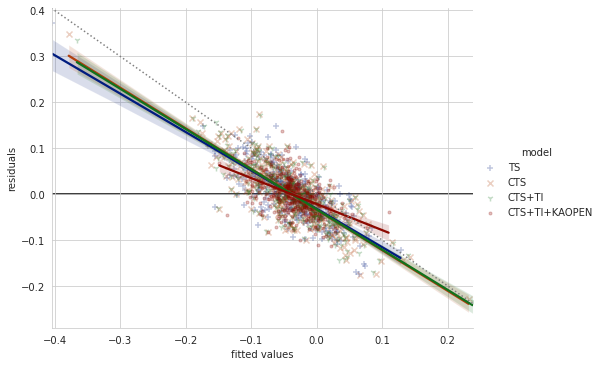

In [33]:
residuals = pd.concat(
    [rafiq_subset['pdynmc_resid'], cts_subset['pdynmc_resid'], cts_ti_subset['pdynmc_resid'], cts_ti_kaopen_subset['pdynmc_resid']],
    keys=['TS', 'CTS', 'CTS+TI', 'CTS+TI+KAOPEN'], names=['model', 'idx']
)

sns.lmplot(x='fitted values', y='residuals', hue='model', height=5, aspect=1.33,
           data=residuals.reset_index().rename(columns={'fitted': 'fitted values'}),
           markers=['+', 'x', '1', '.'], palette=sns.color_palette("dark"), 
           scatter_kws={'alpha': 0.25})
plt.axhline(0, color='black', zorder=-500.0)
plt.autoscale(False)
plt.plot((-1, 1), (1, -1), color='grey', linestyle=':')
save_fig('diffGMM_residual_plot_subset.pdf')

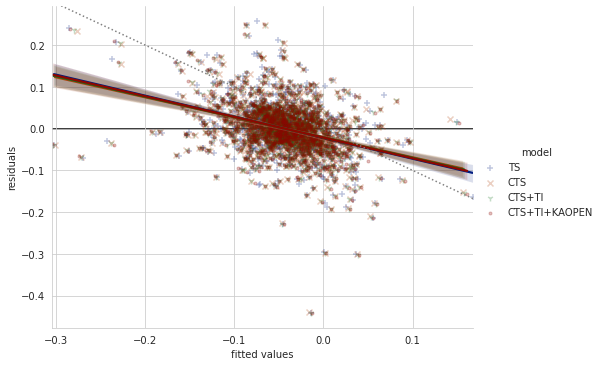

In [34]:
residuals = pd.concat(
    [rafiq_all['pdynmc_resid'], cts_all['pdynmc_resid'], cts_ti_all['pdynmc_resid'], cts_ti_kaopen_all['pdynmc_resid']],
    keys=['TS', 'CTS', 'CTS+TI', 'CTS+TI+KAOPEN'], names=['model', 'idx']
)

sns.lmplot(x='fitted values', y='residuals', hue='model', height=5, aspect=1.33,
           data=residuals.reset_index().rename(columns={'fitted': 'fitted values'}),
           markers=['+', 'x', '1', '.'], palette=sns.color_palette("dark"), 
           scatter_kws={'alpha': 0.25})
plt.axhline(0, color='black', zorder=-500.0)
plt.autoscale(False)
plt.plot((-1, 1), (1, -1), color='grey', linestyle=':')
save_fig('diffGMM_residual_plot_all.pdf')